# Running LLaVa-NeXT-Video: a large multi-modal model on Google Colab

LLaVa-NeXT-Video는 비디오와 이미지와의 상호작용을 가능하게 하는 새로운 대형 비전-언어 모델입니다. 이 모델은 이미지-텍스트 데이터만으로 학습된 이전 시리즈 모델인 [LLaVa-NeXT](https://huggingface.co/docs/transformers/main/en/model_doc/llava_next)를 기반으로 합니다. 구조는 LLaVa-NeXT와 동일하며, 텍스트 숨김 상태와 결합된 비전 숨김 상태를 입력으로 사용하는 디코더 기반의 텍스트 모델입니다.

<img src="http://drive.google.com/uc?export=view&id=1fVg-r5MU3NoHlTpD7_lYPEBWH9R8na_4">

LLaVA-NeXT는 AnyRes 기법을 사용하여 비디오 콘텐츠를 이해하는 데 있어서 뛰어난 성능을 보여주고 있습니다. AnyRes 기법은 고해상도 이미지를 여러 이미지로 자연스럽게 표현하는 방식으로, 이 기법은 비디오를 여러 프레임(마치 LLaVa-NeXT의 여러 이미지처럼)으로 간주하여 일반화가 가능하다는 점에서 비디오 표현에도 자연스럽게 적용됩니다. 현재 비디오용 LLaVa-NeXT의 버전은 여러 가지 개선 사항을 포함하고 있습니다:

- LLaVA-Next-Video는 비디오 데이터에 대해 LLaVA-Next의 지도형 미세 조정(SFT)을 통해 더 나은 비디오 이해 능력을 보여주며, [VideoMME 벤치](https://arxiv.org/pdf/2405.21075)에서 오픈 소스 모델 중 현재 SOTA(최신 기술)를 기록하고 있습니다.
- LLaVA-Next-Video-DPO는 직접 선호 최적화(DPO)를 사용하여 AI 피드백과의 모델 응답을 정렬함으로써 추가적인 성능 향상을 보여줍니다.

Transformers 문서: https://huggingface.co/docs/transformers/main/en/model_doc/llava_next_video  
프로젝트 페이지: https://github.com/LLaVA-VL/LLaVA-NeXT

First we need to install the latest `transformers` from `main`, as the model has just been added. Also we'll install `bitsandbytes` to load the model in lower bits for [memory efficiency](https://huggingface.co/blog/4bit-transformers-bitsandbytes)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade -q accelerate bitsandbytes
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-y6gi59pe
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-y6gi59pe
  Resolved https://github.com/huggingface/transformers.git to commit 816f4424964c1a1631e303b663fc3d68f731e923
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# we need av to be able to read the video
!pip install -q av

## Load the model

다음으로, 우리는 허브에서 모델과 해당 프로세서를 로드합니다.

모델을 4비트로 로드하기 위해 양자화 구성(Quantization Config)을 지정할 것입니다. 자세한 내용은 이 [가이드](https://huggingface.co/blog/4bit-transformers-bitsandbytes)를 참조하세요.

In [ ]:
# 필요한 라이브러리와 모듈을 임포트합니다.
from transformers import BitsAndBytesConfig, LlavaNextVideoForConditionalGeneration, LlavaNextVideoProcessor
import torch

# 양자화 설정을 구성합니다.
# 여기서는 모델을 4비트로 로드하고, 4비트 연산 시 float16 데이터 타입을 사용하도록 설정합니다.
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,                       # 모델을 4비트로 로드
    bnb_4bit_compute_dtype=torch.float16      # 4비트 계산 시 float16 데이터 타입 사용
)

# 사전 학습된 프로세서를 허브에서 로드합니다.
# 이 프로세서는 비디오 데이터를 모델이 처리할 수 있는 형식으로 변환하는 역할을 합니다.
processor = LlavaNextVideoProcessor.from_pretrained("llava-hf/LLaVA-NeXT-Video-7B-hf")

# 추가 설정: patch_size와 vision_feature_select_strategy
# processor.patch_size = 256  # 패치 크기 설정
# processor.vision_feature_select_strategy = "average_pooling"  # 비전 특징 선택 전략 설정

# 사전 학습된 모델을 허브에서 로드합니다.
# 양자화 설정을 적용하고, 모델을 자동으로 적절한 디바이스(CPU/GPU)에 할당합니다.
model = LlavaNextVideoForConditionalGeneration.from_pretrained(
    "llava-hf/LLaVA-NeXT-Video-7B-hf",        # 모델 이름 및 경로
    quantization_config=quantization_config, # 앞서 정의한 양자화 설정 적용
    device_map='auto'                         # 모델을 자동으로 적절한 디바이스에 할당
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Preparing the video and image inputs

비디오를 읽기 위해 `av`를 사용하여 8개의 프레임을 샘플링할 것입니다. 비디오가 길 경우 더 많은 프레임을 샘플링해 볼 수 있습니다. 모델은 32개의 프레임으로 학습되었지만, LLM 백본의 최대 시퀀스 길이 범위 내라면 더 많은 프레임도 처리할 수 있습니다.

이 방법으로 중요한 장면들을 샘플링하여 모델이 비디오의 전체적인 내용을 파악할 수 있도록 도울 수 있습니다.

In [ ]:
import av
import numpy as np
from matplotlib import pyplot as plt

def read_video_pyav(container, frame_indices):
    """
    지정된 프레임 인덱스에 해당하는 프레임을 PyAV를 사용하여 읽어옵니다.

    Args:
        container (av.container.InputContainer): 열려 있는 PyAV 컨테이너 객체.
        frame_indices (list or np.ndarray): 읽어올 프레임의 인덱스 리스트.

    Returns:
        np.ndarray: 읽어온 프레임들을 포함하는 NumPy 배열 (frames, height, width, channels).
    """
    frames = []
    frame_counter = 0
    frame_indices_set = set(frame_indices)  # 빠른 조회를 위해 집합으로 변환

    for frame in container.decode(video=0):
        if frame_counter in frame_indices_set:
            img = frame.to_rgb().to_ndarray()
            frames.append(img)
            if len(frames) == len(frame_indices):
                break
        frame_counter += 1

    return np.array(frames)

In [ ]:
def download_and_sample_video_local(video_path, num_frames=8):
    """
    로컬 비디오 파일을 열고 지정된 수의 프레임을 샘플링합니다.
    또한 영상의 총 프레임 수와 영상 시간을 출력합니다.

    Args:
        video_path (str): 로컬 비디오 파일 경로.
        num_frames (int): 샘플링할 프레임 수.

    Returns:
        np.ndarray: 샘플링된 프레임들을 포함하는 NumPy 배열.
    """
    try:
        # PyAV 컨테이너 열기
        container = av.open(video_path)
    except FileNotFoundError:
        print(f"비디오 파일을 찾을 수 없습니다: {video_path}")
        return None
    except av.AVError as e:
        print(f"비디오 파일을 여는 중 오류가 발생했습니다: {e}")
        return None

    # 비디오 스트림 가져오기
    stream = container.streams.video[0]

    # 총 프레임 수 가져오기
    total_frames = stream.frames
    if total_frames is None:
        # 총 프레임 수가 명시되지 않은 경우, 프레임을 모두 읽어 셉니다.
        total_frames = 0
        for packet in container.demux(stream):
            for frame in packet.decode():
                total_frames += 1
        container.close()
        container = av.open(video_path)  # 다시 열기

    # 총 영상 길이(초) 가져오기
    duration = float(container.duration / av.time_base)

    print(f"영상 길이: {duration:.2f}초")
    print(f"총 프레임 수: {total_frames}")

    # 비디오에서 균등하게 프레임 인덱스 샘플링
    indices = np.linspace(0, total_frames - 1, num_frames).astype(int)
    print(f"샘플링된 프레임 인덱스: {indices}")

    # 샘플링된 프레임 인덱스를 사용하여 프레임을 읽어옵니다.
    clip = read_video_pyav(container, indices)

    return clip

영상 길이: 118.24초
총 프레임 수: 7090
샘플링된 프레임 인덱스: [   0 1012 2025 3038 4050 5063 6076 7089]


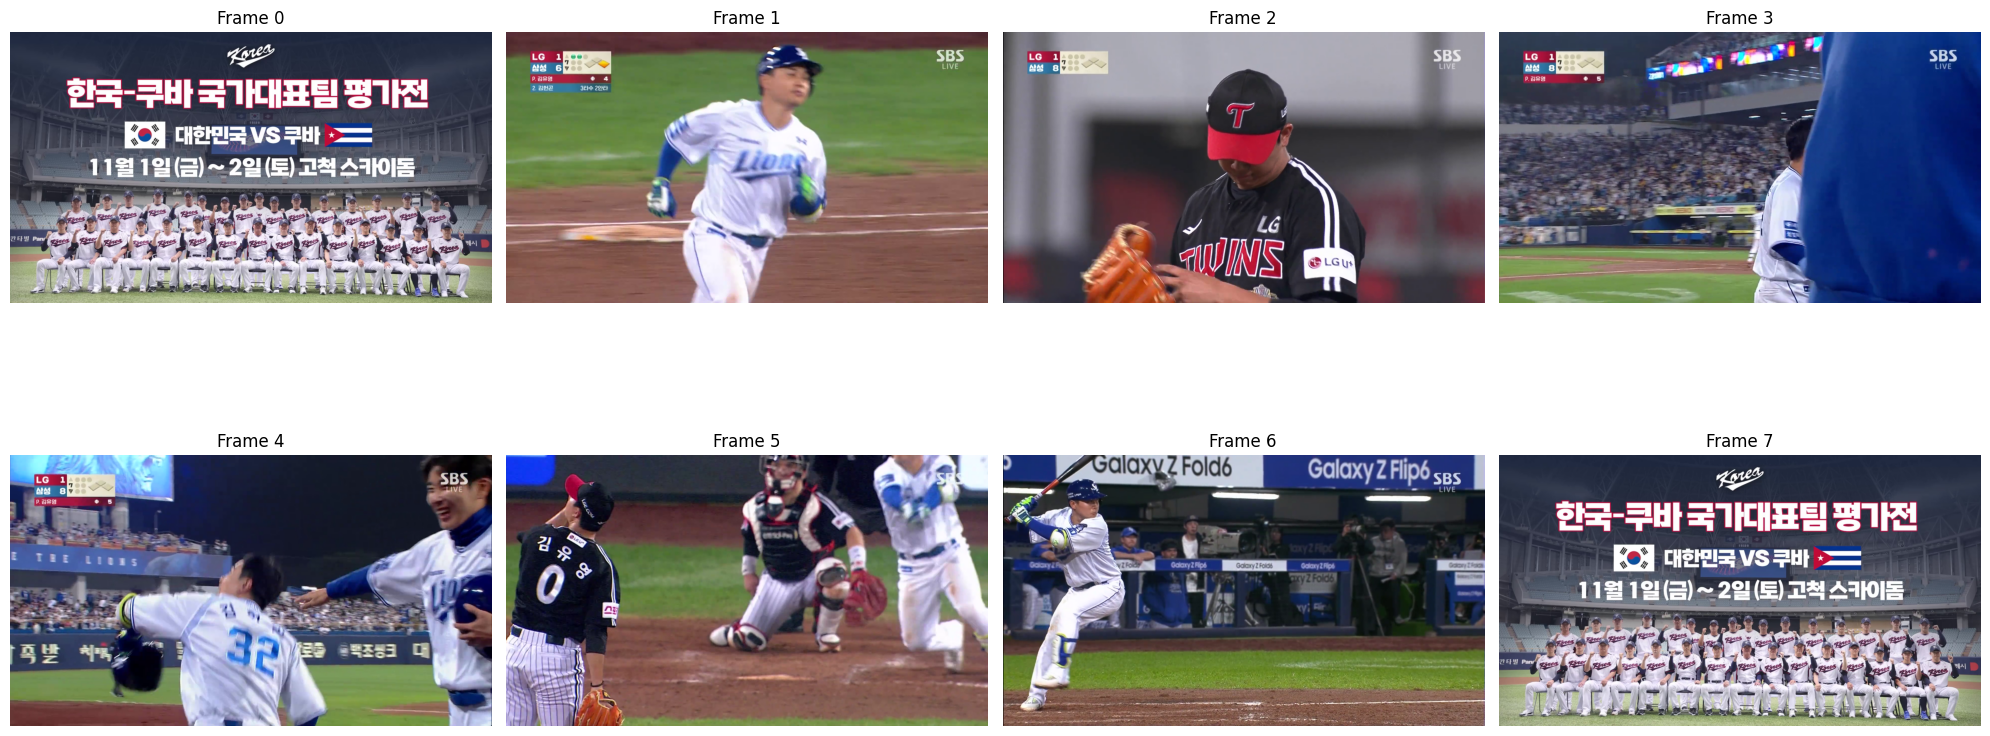

In [ ]:
def plot_clips(clips, titles):
    """
    샘플링된 프레임을 시각화합니다.

    Args:
        clips (np.ndarray): 샘플링된 프레임들.
        titles (list): 각 프레임의 제목 리스트.
    """
    if clips is None or len(clips) == 0:
        print("시각화할 프레임이 없습니다.")
        return

    num_clips = len(clips)
    cols = 4
    rows = (num_clips + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < num_clips:
            ax.imshow(clips[i])
            ax.set_title(titles[i])
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# 비디오 파일 경로 지정 (로컬 파일 사용)
video_path_1 = "/content/drive/MyDrive/kakaotech-14-ai/test_video.mp4"

# 첫 번째 비디오 다운로드 및 샘플링 (8프레임)
clip_baby = download_and_sample_video_local(video_path_1, num_frames=8)

# 샘플링된 프레임을 확인하기 위한 시각화
if clip_baby is not None:
    plot_clips(clip_baby, [f"Frame {i}" for i in range(len(clip_baby))])

## 프롬프트 준비 및 생성

프롬프트에서 비디오를 참조할 때는 특별한 `<video>` 또는 `<image>` 토큰을 사용할 수 있습니다. 사람이 입력한 텍스트와 모델의 응답을 구분하기 위해, 각각 USER와 ASSISTANT를 사용합니다(참고: 이는 해당 체크포인트에서만 적용됩니다). 형식은 다음과 같습니다:

`USER: <video>\n<prompt> ASSISTANT:`

즉, 프롬프트의 끝에는 항상 ASSISTANT:로 끝내야 합니다.

각 체크포인트마다 백본 언어 모델에 따라 프롬프트 형식이 다르기 때문에, USER와 ASSISTANT를 수동으로 추가하는 것은 실수하기 쉽습니다. 다행히도 `apply_chat_template`을 사용하여 이를 더 쉽게 만들 수 있습니다.

챗 템플릿은 jinja로 작성된 특별한 템플릿이며 모델의 구성에 추가되어 있습니다. `apply_chat_template`를 호출하면, jinja 템플릿이 입력한 텍스트 지시사항으로 채워집니다.

챗 템플릿을 사용하려면 역할과 내용 키가 있는 메시지 목록을 생성하고, 이를 `apply_chat_template()` 메서드에 전달하기만 하면 됩니다. 그러면 바로 사용할 수 있는 출력물이 생성됩니다! 모델 생성의 입력으로 챗 템플릿을 사용할 때는 `add_generation_prompt=True`를 사용하는 것이 좋습니다. 자세한 내용은 [문서](https://huggingface.co/docs/transformers/main/en/chat_templating)를 참조하세요.

In [ ]:
# 각 "content"는 사전의 리스트이며, 이미지/비디오/텍스트 모달리티를 추가할 수 있습니다.
conversation = [
      {
          "role": "user",  # 메시지의 역할을 'user'로 설정
          "content": [
              {"type": "text", "text": "What's the situation with this video right now?"},  # 텍스트 메시지 추가
              {"type": "video"},  # 비디오 모달리티 추가
              ],
      },
]

# 대화 템플릿을 적용하여 프롬프트 생성
# add_generation_prompt=True를 설정하여 생성 프롬프트를 추가
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
print(prompt)


USER: <video>
What's the situation with this video right now? ASSISTANT:


In [ ]:
# As you can see we got the USER: ASSISTANT: format prompt
prompt

"USER: <video>\nWhat's the situation with this video right now? ASSISTANT:"

In [ ]:
# 생성 매개변수를 설정합니다.
generate_kwargs = {
    "max_new_tokens": 200,       # 생성할 최대 새로운 토큰 수를 100으로 설정
    "do_sample": True,           # 샘플링을 사용하여 다양성 있는 출력을 생성
    "top_p": 0.9                 # 누적 확률이 0.9가 될 때까지 토큰을 샘플링 (Top-p 샘플링)
}

# (1) 먼저 입력 데이터를 전처리합니다.
inputs = processor(
    [prompt],                   # 프롬프트 리스트 전달
    videos=[clip_baby],         # 비디오 클립 리스트 전달
    padding=True,               # 패딩을 사용하여 시퀀스 길이 맞춤
    truncation=True,            # 시퀀스를 자르는 기능을 활성화하여 최대 길이 맞춤
    return_tensors="pt"         # PyTorch 텐서 형식으로 반환
).to(model.device)              # 입력 데이터를 모델의 디바이스로 이동

# (2) 생성 매개변수를 사용하여 모델에서 텍스트 생성
try:
    output = model.generate(
        **inputs,                # 전처리된 입력 데이터 전달
        **generate_kwargs        # 생성 매개변수 전달
    )

    # (3) 생성된 텍스트 디코딩 및 출력
    generated_text = processor.batch_decode(
        output,                  # 생성된 출력 텍스트 텐서
        skip_special_tokens=True # 특수 토큰을 무시하고 디코딩
    )

except ValueError as e:
    print(f"오류 발생: {e}")
    print("비디오 특징과 토큰이 일치하지 않는 문제를 해결하기 위해 비디오 전처리 및 입력 데이터를 조정하세요.")


In [ ]:
# 최종 생성된 텍스트 출력
print(generated_text)

['USER: \nWhat\'s the situation with this video right now? ASSISTANT: The video shows a baseball game in progress with two teams, one wearing white uniforms with "Twins" written across the chest, and the other wearing blue uniforms with a white logo. The camera focuses on a player from the "Twins" team in the outfield, who is preparing to throw the ball to first base. The scene appears to be in the middle of the game, as the players are in their positions, ready for the next play. The exact situation might depend on the inning, but it\'s a standard moment in the baseball gameplay where one team is attempting to get the runners from the opposing team out by throwing the ball back to the first baseman. The first baseman is already in position with his glove on, ready to catch the ball if it\'s a hit or to tag out a baserunner if it\'s a force out attempt.']


In [ ]:
!pip install deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.0 MB/s eta 0:00:00


In [ ]:
# 필요한 라이브러리를 임포트합니다.
from deep_translator import GoogleTranslator

# generated_text가 리스트인 경우, 첫 번째 요소를 가져옵니다.
if isinstance(generated_text, list):
    generated_text_str = generated_text[0]  # 리스트의 첫 번째 요소를 가져옵니다.
else:
    generated_text_str = generated_text  # 이미 문자열인 경우 그대로 사용합니다.

# 'ASSISTANT:'를 기준으로 텍스트를 분할합니다.
parts = generated_text_str.split('ASSISTANT:')
assistant_text = parts[1].strip() if len(parts) > 1 else ''  # ASSISTANT의 응답 부분 추출

# 번역기를 초기화합니다.
translator = GoogleTranslator(source='auto', target='ko')

# ASSISTANT의 응답 부분을 한국어로 번역합니다.
translation = translator.translate(assistant_text)

# 번역된 ASSISTANT의 응답 부분만 출력합니다.
print(translation)

이 영상은 두 팀이 야구 경기를 하는 모습을 보여줍니다. 한 팀은 가슴에 "Twins"라고 쓰인 흰색 유니폼을 입고 있고, 다른 한 팀은 흰색 로고가 있는 파란색 유니폼을 입고 있습니다. 카메라는 외야에 있는 "Twins" 팀의 선수에게 초점을 맞추고 있으며, 그는 1루로 공을 던질 준비를 하고 있습니다. 이 장면은 선수들이 각자의 위치에 있고 다음 플레이를 준비하고 있는 경기 중간에 있는 것처럼 보입니다. 정확한 상황은 이닝에 따라 다를 수 있지만, 야구 게임 플레이에서 한 팀이 1루수에게 공을 다시 던져 상대 팀의 주자를 아웃시키려는 표준적인 순간입니다. 1루수는 이미 글러브를 낀 채 위치에 있고, 공이 안타일 경우 공을 잡을 준비가 되어 있고, 강제 아웃 시도일 경우 주자를 태그 아웃시킬 준비가 되어 있습니다.
